In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.filters
import skimage.io
import re

from scalabel.alignment import align_homography, align_regularised_flow
from scalabel.features import global_matches
from scalabel.calibrate import Calibrator
from scalabel.perspective import PerspectiveCorrection
from scalabel.labels import separate_labels
from scalabel.post_processing import improve_contrast

# Example pipeline

In [3]:
data_dir = Path('data', 'Test 3_Flies_GreyFoam')
specimen_prefix = "0003"

filenames = sorted(filename for filename in data_dir.iterdir() if specimen_prefix in filename.stem)[2:]
images = [(re.findall('ALICE(\d*)', f.name)[0], skimage.io.imread(f.name)) for f in filenames]

### STAGE ONE: Perspective Correction

In [6]:
alignment = PerspectiveCorrection(images)

warped = alignment.corrected_images
display = alignment.calibration_pattern_images

fig, axes = plt.subplots(4, 2, figsize=(12, 24), squeeze=True)

for ax, name, (aligned, original) in zip(axes, filenames, zip(warped, display)):
    ax[0].imshow(original)
    ax[0].axis('off')
    ax[0].set(title=name)
    ax[1].imshow(aligned)
    ax[1].axis('off')

### Find correspondences

In [4]:
images = warped

points = global_matches(images)

### Separate individual labels

In [5]:
label_images = separate_labels(images, points, visualise=True)

Completed iteration 0
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29


### Display results

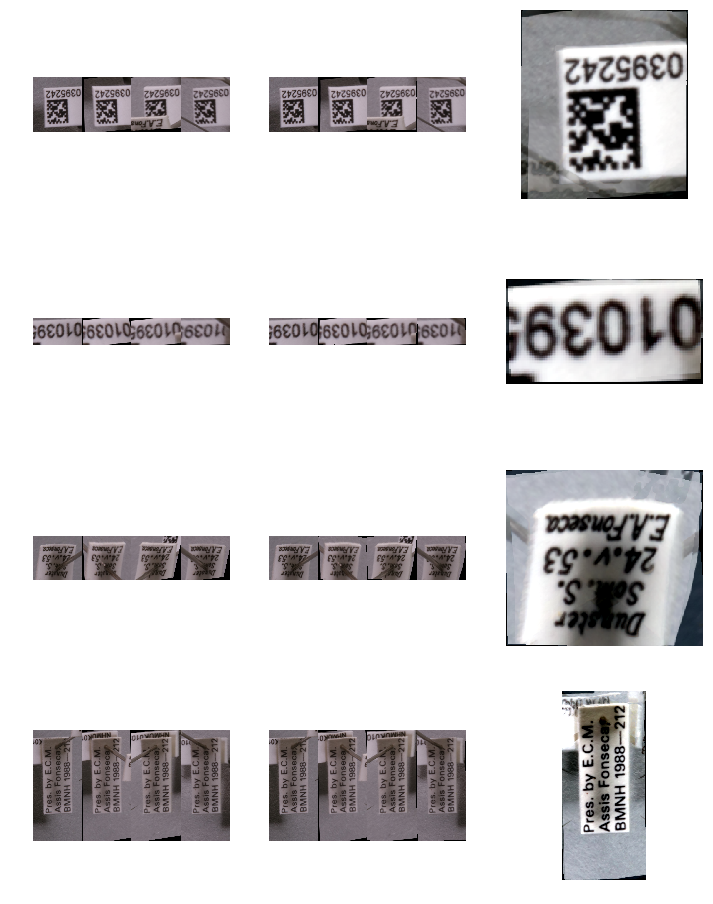

In [6]:
fig, axes = plt.subplots(len(label_images), 3, figsize=(12, len(label_images) * 4))

for label, ax in zip(label_images, axes):
    warped = [skimage.img_as_float(label[0])]
    aligned = [skimage.img_as_float(label[0])]

    warped += [align_homography(label[j], label[0]) for j in range(1, 4)]
    ax[0].imshow(np.concatenate(warped, axis=1))
    ax[0].axis('off')

    aligned += [align_regularised_flow(warped[j], warped[0]).filled(fill_value=0) for j in range(1, 4)]
    ax[1].imshow(np.concatenate(aligned, axis=1))
    ax[1].axis('off')

    ax[2].imshow(improve_contrast(np.median(np.stack(aligned), axis=0)))
    ax[2].axis('off')